In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [2]:
df = pd.read_csv("../data/raw/Dataset.csv")
df

,Protocol,Info,Length,Delta,Type
0,HCI_EVT,Rcvd Link Key Request,9,0.010473,au_rand_flooding
1,HCI_CMD,Sent Link Key Request Negative Reply,10,0.010473,au_rand_flooding
2,HCI_EVT,Rcvd Link Key Request,9,0.017913,au_rand_flooding
3,HCI_EVT,Rcvd Command Complete (Link Key Request Negati...,13,0.002642,au_rand_flooding
4,HCI_CMD,Sent Link Key Request Negative Reply,10,0.002882,au_rand_flooding
...,...,...,...,...,...
8997,RFCOMM,Sent UIH Channel=12 UID,14,0.006531,normal
8998,HCI_EVT,Rcvd Number of Completed Packets,8,0.004969,normal
8999,OBEX,Sent Continue,21,0.014489,normal
9000,LMP,LMP_power_control_req,64,0.003510,normal


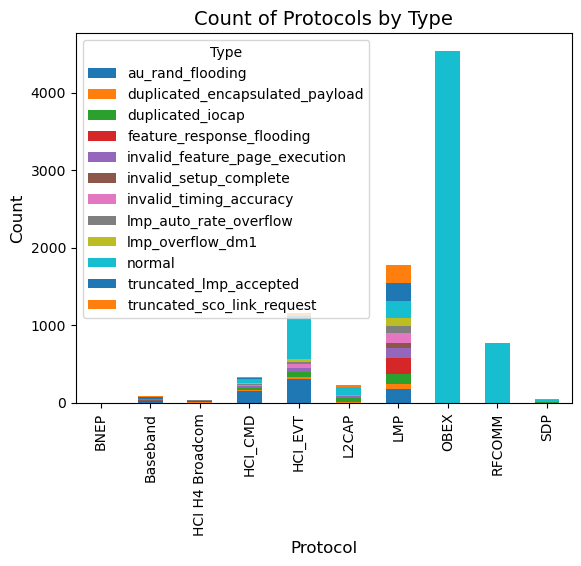

In [3]:
stacked_data = df.groupby(['Protocol', 'Type']).size().unstack(fill_value=0)

stacked_data.plot(kind='bar', stacked=True)

plt.xlabel('Protocol', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.legend(title='Type')

plt.title('Count of Protocols by Type', fontsize=14)

plt.savefig("../figures/Count of Protocols by Type.png", bbox_inches='tight')
plt.show()

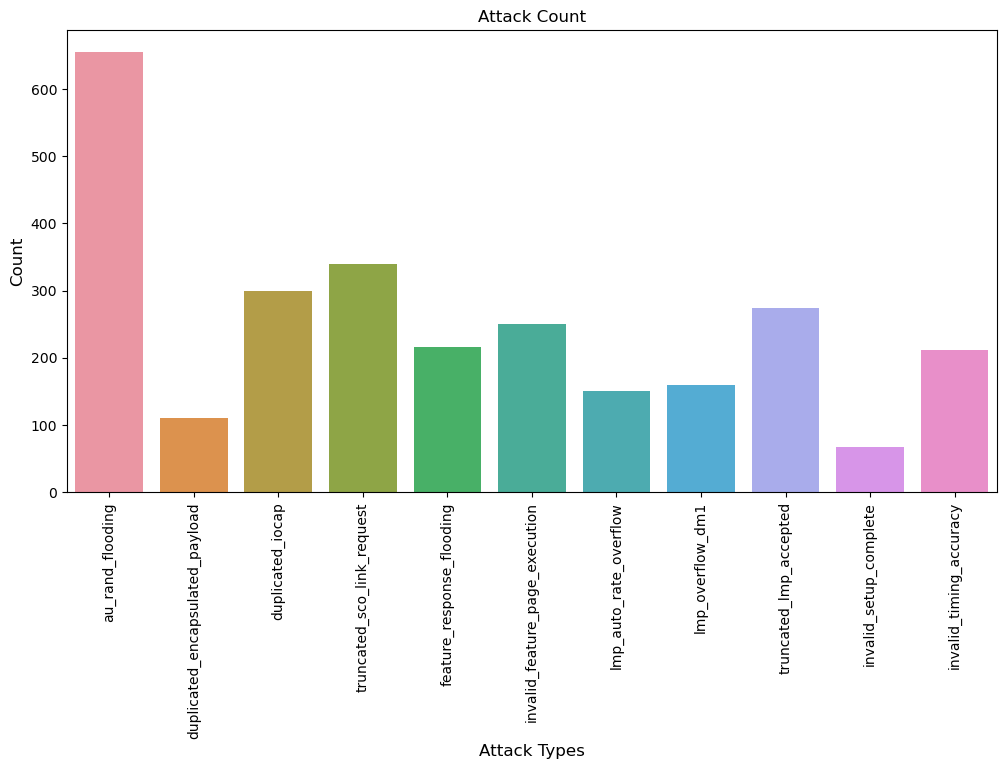

In [4]:
plt.figure(figsize=(12, 6)) 

sns.countplot(data=df[df["Type"] != "normal"], x='Type')

plt.xlabel('Attack Types', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title("Attack Count")
plt.xticks(rotation=90)

plt.savefig("../figures/Attack Count.png", bbox_inches='tight')
plt.show()

In [5]:
df["is_attack"] = df["Type"].apply(lambda x: x!="normal")
df.head()

,Protocol,Info,Length,Delta,Type,is_attack
0,HCI_EVT,Rcvd Link Key Request,9,0.010473,au_rand_flooding,True
1,HCI_CMD,Sent Link Key Request Negative Reply,10,0.010473,au_rand_flooding,True
2,HCI_EVT,Rcvd Link Key Request,9,0.017913,au_rand_flooding,True
3,HCI_EVT,Rcvd Command Complete (Link Key Request Negati...,13,0.002642,au_rand_flooding,True
4,HCI_CMD,Sent Link Key Request Negative Reply,10,0.002882,au_rand_flooding,True


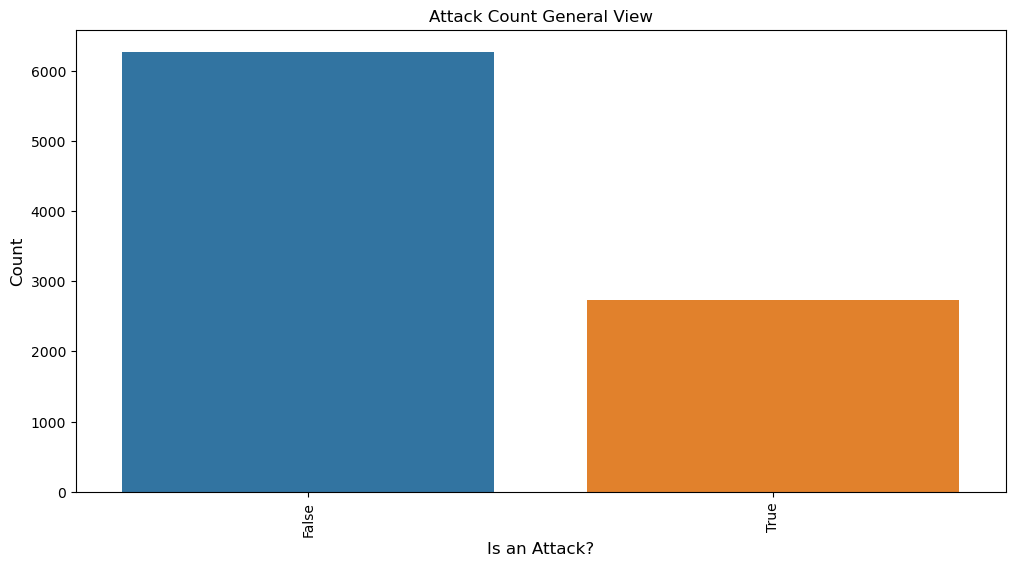

In [6]:
plt.figure(figsize=(12, 6)) 

sns.countplot(data=df, x='is_attack')

plt.xlabel('Is an Attack?', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title("Attack Count General View")
plt.xticks(rotation=90)

plt.savefig("../figures/Attack Count General View.png", bbox_inches='tight')
plt.show()

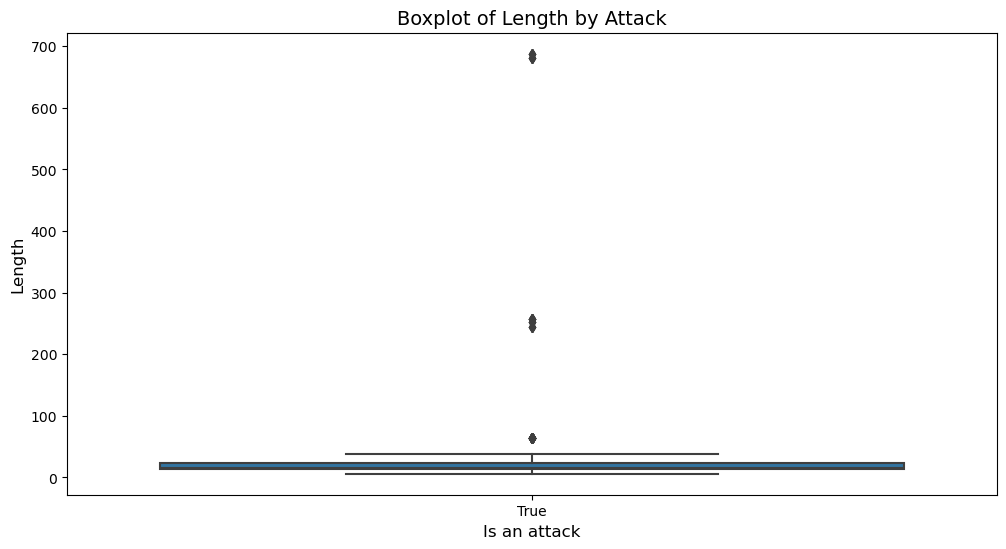

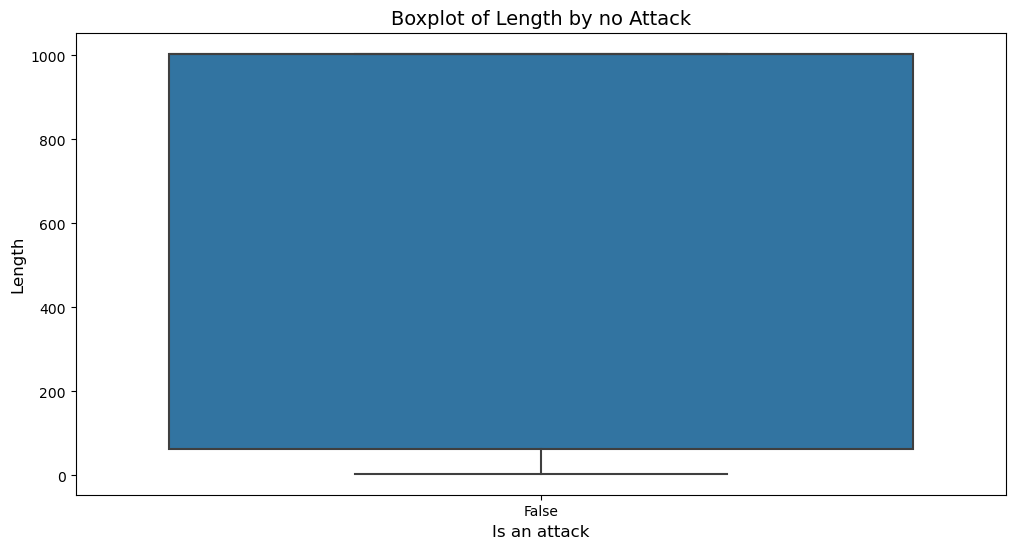

In [7]:
for attack in [True, False]:
    sub_attack = df[df['is_attack'] == attack]

    plt.figure(figsize=(12, 6)) 
    sns.boxplot(data=sub_attack, x='is_attack', y='Length')

    plt.xlabel('Is an attack', fontsize=12)
    plt.ylabel('Length', fontsize=12)
    if attack:
        txt = ""
    else:
        txt = "no "
    plt.title(f'Boxplot of Length by {txt}Attack', fontsize=14)
    plt.savefig(f"../figures/Boxplot of Length by {txt} Attack.png", bbox_inches='tight')

    plt.show()

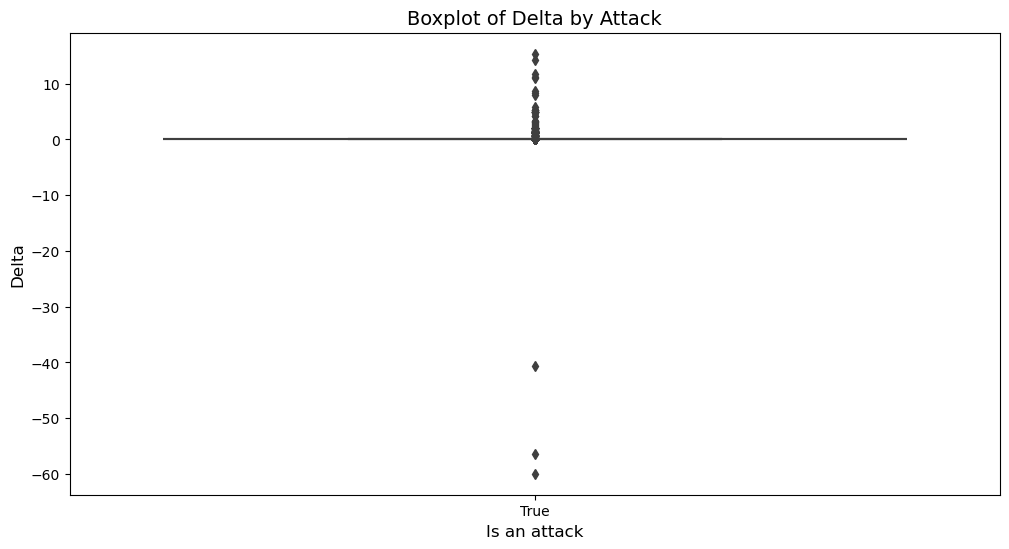

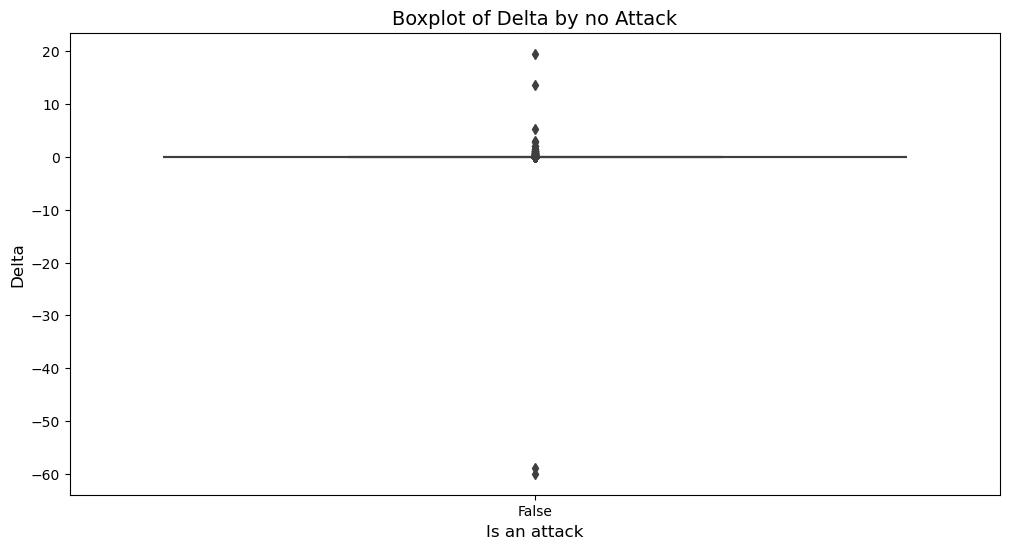

In [8]:
for attack in [True, False]:
    sub_attack = df[df['is_attack'] == attack]

    plt.figure(figsize=(12, 6))  # Tamaño personalizado, ajusta según tus necesidades
    sns.boxplot(data=sub_attack, x='is_attack', y='Delta')

    plt.xlabel('Is an attack', fontsize=12)
    plt.ylabel('Delta', fontsize=12)
    if attack:
        txt = ""
    else:
        txt = "no "
    plt.title(f'Boxplot of Delta by {txt}Attack', fontsize=14)
    plt.savefig(f"../figures/Boxplot of Delta by {txt} Attack.png", bbox_inches='tight')

    plt.show()

In [9]:
df["Delta"].describe()

count    9002.000000
mean        0.021944
std         1.408453
min       -59.990105
25%         0.001381
50%         0.003353
75%         0.005305
max        19.542984
Name: Delta, dtype: float64

In [10]:
%%writefile ../scr/code/preprocessing.py
import pandas as pd

def parse_Delta(delta_col_val):
    if delta_col_val <= 0.001381:
        return 0.001380
    elif delta_col_val >= 0.005305:
        return 0.005306
    return delta_col_val

def custom_drop_dummies(col_name, col, metadata):
    ans = pd.DataFrame()
    for elem in metadata:
        col_list = list()
        for item in list(col):
            if elem == item:
                col_list.append(1)
            else:
                col_list.append(0)
        ans[f"{col_name}_{elem}"] = col_list
    return ans

def preprocess(X, metadata):
    ans = pd.DataFrame()
    ans["Delta"] = X["Delta"].apply(parse_Delta)
    temp = custom_drop_dummies("Protocol", X["Protocol"], metadata)
    for col in temp.columns:
        ans[col] = temp[col]
    return ans

Overwriting ../scr/code/preprocessing.py


In [11]:
import sys
sys.path.append('../') 
from scr.code.preprocessing import preprocess

In [12]:
unique_protocols = list(df['Protocol'].unique())
unique_attacks = list(df["Type"].unique())
dic_metadata = {
    "unique_protocols": unique_protocols,
    "attack_types": {attack:i for attack, i in zip(unique_attacks, range(len(unique_attacks)))}
}
#dic_metadata

In [13]:
import json
with open("../scr/metadata/metadata.json", "w") as f:
    json.dump(dic_metadata, f, indent=4)

In [14]:
df_bluetooth = preprocess(df, unique_protocols)
df_bluetooth["is_attack"] = df["is_attack"].apply(lambda x: 1 if x else 0)
df_bluetooth.head()

,Delta,Protocol_HCI_EVT,Protocol_HCI_CMD,Protocol_HCI H4 Broadcom,Protocol_Baseband,Protocol_LMP,Protocol_L2CAP,Protocol_SDP,Protocol_BNEP,Protocol_RFCOMM,Protocol_OBEX,is_attack
0,0.005306,1,0,0,0,0,0,0,0,0,0,1
1,0.005306,0,1,0,0,0,0,0,0,0,0,1
2,0.005306,1,0,0,0,0,0,0,0,0,0,1
3,0.002642,1,0,0,0,0,0,0,0,0,0,1
4,0.002882,0,1,0,0,0,0,0,0,0,0,1


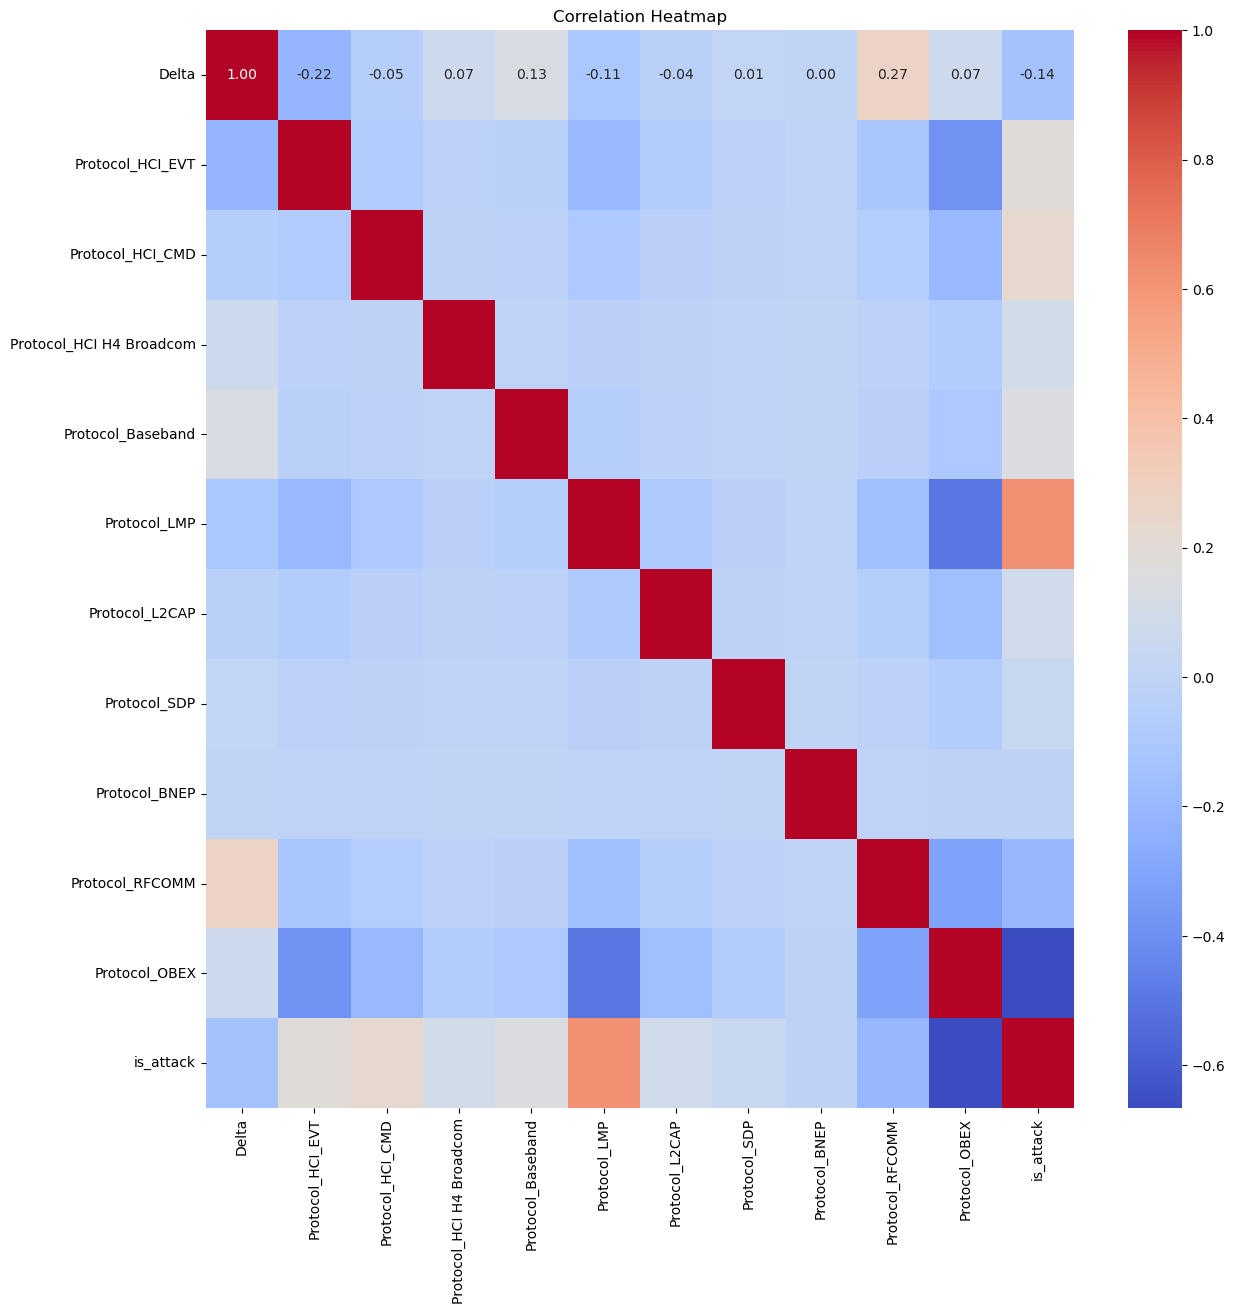

In [15]:
correlation_matrix = df_bluetooth.corr()

# Crear el heatmap de la correlación
plt.figure(figsize=(14, 14))  # Tamaño personalizado, ajusta según tus necesidades
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

plt.title('Correlation Heatmap')


plt.savefig("../figures/Correlation Heatmap.png", bbox_inches='tight')
plt.show()

In [16]:
df_bluetooth.to_parquet("../data/processed/bluetooth.parquet")

In [17]:
df_bluetooth["kind_Attack"] = df["Type"].apply(lambda x: dic_metadata["attack_types"][x])
df_bluetooth.head()

,Delta,Protocol_HCI_EVT,Protocol_HCI_CMD,Protocol_HCI H4 Broadcom,Protocol_Baseband,Protocol_LMP,Protocol_L2CAP,Protocol_SDP,Protocol_BNEP,Protocol_RFCOMM,Protocol_OBEX,is_attack,kind_Attack
0,0.005306,1,0,0,0,0,0,0,0,0,0,1,0
1,0.005306,0,1,0,0,0,0,0,0,0,0,1,0
2,0.005306,1,0,0,0,0,0,0,0,0,0,1,0
3,0.002642,1,0,0,0,0,0,0,0,0,0,1,0
4,0.002882,0,1,0,0,0,0,0,0,0,0,1,0


In [18]:
df_bluetooth.is_attack.value_counts()

is_attack
0    6269
1    2733
Name: count, dtype: int64

In [19]:
df_bluetooth = df_bluetooth[df_bluetooth["is_attack"] == 1]
final_cols = list()
for col in df_bluetooth.columns:
    if col != "is_attack": 
        final_cols.append(col)

df_bluetooth = df_bluetooth[final_cols]

In [20]:
df_bluetooth["kind_Attack"].value_counts()

kind_Attack
0     655
3     340
2     299
8     274
5     250
4     216
10    211
7     159
6     151
1     111
9      67
Name: count, dtype: int64

In [21]:
df_bluetooth.to_parquet("../data/processed/attacks.parquet")